## TODO: 
- balansing the classes
- measure AUC 
- compare to leaderboard


# Import libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import funcs
import load_data

# Functions/Classes

In [2]:
class Info_Class:
    def __init__(self, pathologies, class_weights, target_size, steps_per_epoch, validation_steps):
        self.pathologies      = pathologies
        self.class_weights    = class_weights
        self.target_size      = target_size
        self.steps_per_epoch  = steps_per_epoch
        self.validation_steps = validation_steps                

## Selecting the pathologies

In [3]:
pathologies = ["No Finding", "Enlarged Cardiomediastinum" , "Cardiomegaly" , "Lung Opacity" , "Lung Lesion", "Edema" , "Consolidation" , "Pneumonia" , "Atelectasis" , "Pneumothorax" , "Pleural Effusion" , "Pleural Other" , "Fracture" , "Support Devices"]

## Loading the raw table

In [4]:
""" Label Structure
    positive (exist):            1.0
    negative (doesn't exist):   -1.0
    Ucertain                     0.0
    no mention                   NaN """


# dir = '/Users/artinmac/GoogleDrive/RESEARCH/projects/Data7.chest_xray'
dir = '/groups/jjrodrig/projects/chest/dataset/chexpert'
train = pd.read_csv(dir + '/train.csv')
test  = pd.read_csv(dir + '/valid.csv')

print('before sample-pruning')
print('train:',train.shape)
print('test:',test.shape)

train.head()

before sample-pruning
train: (223414, 19)
test: (234, 19)


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


## Adding full directory

In [5]:
train['full_path'] = dir +'/' + train['Path']
test['full_path'] = dir +'/' + test['Path']

In [6]:
# train.describe()


## Extracting the pathologies of interest

In [7]:
train = load_data.cleaning_up_dataframe(train, pathologies, 'train')
test  = load_data.cleaning_up_dataframe(test, pathologies , 'test')

In [8]:
train.Edema.unique()

array(['neg', nan, 'pos', 'uncertain'], dtype=object)

## Selecting a few cases

In [9]:
max_sample = 1000000
train = train.iloc[:max_sample,:]

In [10]:
# train.shape

## separating the uncertain samples

In [11]:
train_uncertain = train.copy()
for name in pathologies:
    train = train.loc[train[name]!='uncertain']
    
train_uncertain = train_uncertain.drop(train.index)

## Splitting train/validatiion

In [12]:
valid = train.sample(frac=0.2,random_state=1)
train = train.drop(valid.index)

print('\nafter sample-pruning')
print('train (certain):',train.shape)
print('train (uncertain):',train_uncertain.shape)
print('valid:',valid.shape)
print('test:',test.shape,'\n')


after sample-pruning
train (certain): (86920, 20)
train (uncertain): (52940, 20)
valid: (21730, 20)
test: (169, 20) 



In [13]:
# label_counts = train[pathologies].replace(-1,1).replace(0,1).sum()

# fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
# ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
# ax1.set_xticks(np.arange(len(label_counts))+0.5)
# _ = ax1.set_xticklabels(label_counts.index, rotation = 90)

# train['No Finding'].hist()

# pathologies = ["No Finding", "Enlarged Cardiomediastinum" , "Cardiomegaly" , "Lung Opacity" , "Lung Lesion", "Edema" , "Consolidation" , "Pneumonia" , "Atelectasis" , "Pneumothorax" , "Pleural Effusion" , "Pleural Other" , "Fracture" , "Support Devices"]

# no_finding_indexes = train[train['No Finding']==1].index
# for disease in pathologies:
#     if disease != 'No Finding':
#         train.loc[no_finding_indexes, disease] = -1

train.Edema.unique()



array(['neg', nan, 'pos'], dtype=object)

## Changing classes from string to integer

In [14]:
train = train.replace('pos',1).replace('neg',0)
valid = valid.replace('pos',1).replace('neg',0)
test  = test.replace('pos',1).replace('neg',0)

### Changing the NaN values for parents with at lease 1 TRUE child to TRUE

In [15]:
train = load_data.replacing_parent_nan_values_with_one_if_child_exist(train)
valid = load_data.replacing_parent_nan_values_with_one_if_child_exist(valid)

### Tagging the missing labels; this number "-0.5" will later be masked during measuring the loss

In [17]:
train = train.replace(np.nan,-5.0)
valid = valid.replace(np.nan,-5.0)

## Class weights

In [18]:
L = len(pathologies)
class_weights = np.ones(L)/L

In [19]:
# train.loc[:10]

shape: (320, 389) MAX: 255 MIN: 0


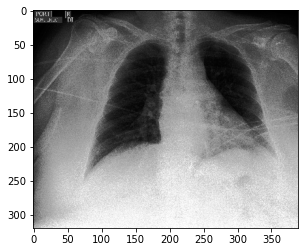

In [20]:
sample_dir = train.full_path.tolist()[0]

im = plt.imread(sample_dir)
print('shape:',im.shape,'MAX:',im.max(),'MIN:',im.min())

plt.imshow(im,cmap='gray')

CPU times: user 4.07 s, sys: 25.4 ms, total: 4.1 s
Wall time: 4.1 s


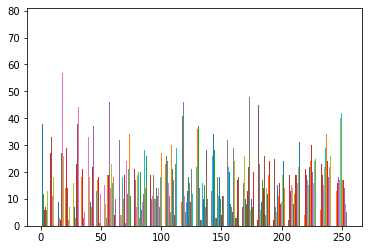

In [21]:
%%time
h = plt.hist(im[:],bins=20)


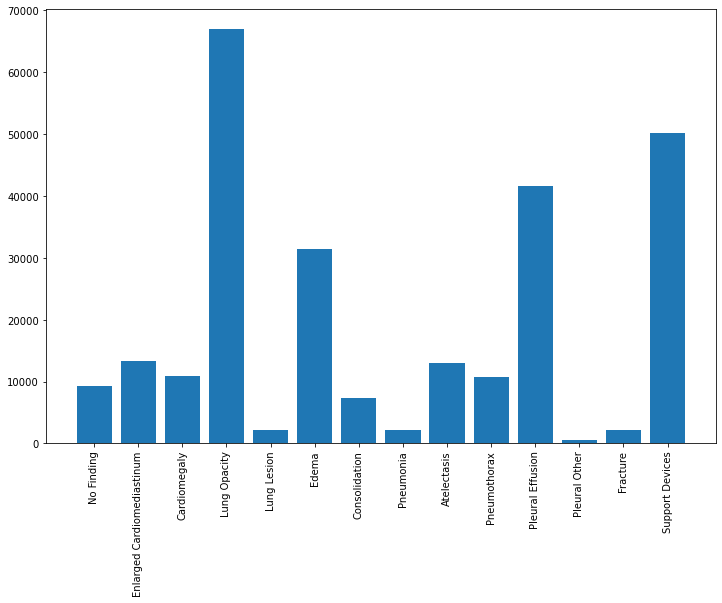

In [22]:
train2 = train.copy()
train2 = train2.replace(-5.0,np.nan)
label_counts = train2[pathologies].sum()

fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)


# Keras Generator

In [21]:
# generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# target_size =  (224,224)
# class_mode='raw'
# color_mode = 'rgb' # this is actually grayscale. but because densenet input is rgb, is set to rgb
# y_col = list(pathologies)
# output_shapes = ([None,224,224,3],[None,len(y_col)]) 
# output_types= (tf.float32,tf.float32)

## Train/Validation generator

In [22]:
# train_generator = generator.flow_from_dataframe(dataframe=train, x_col='Path', y_col=y_col,color_mode=color_mode,directory=dir, target_size=target_size, batch_size=batch_size, class_mode=class_mode, shuffle=False)

# steps_per_epoch  = int(len(train_generator.filenames)/batch_size)
# train_data = tf.data.Dataset.from_generator(lambda: train_generator,output_types=output_types)


# valid_generator = generator.flow_from_dataframe(dataframe=valid, x_col='Path', y_col=y_col,color_mode=color_mode,directory=dir, target_size=target_size, batch_size=batch_size, class_mode=class_mode, shuffle=False)  

# validation_steps = int(len(valid_generator.filenames)/batch_size)
# valid_data = tf.data.Dataset.from_generator(lambda: valid_generator,output_types=output_types)


# Info = Info_Class(pathologies=pathologies, class_weights=class_weights, target_size=target_size, validation_steps=validation_steps,steps_per_epoch=steps_per_epoch)

## Test generator

In [23]:
# test_generator = generator.flow_from_dataframe(dataframe=test, x_col='Path', y_col=y_col,color_mode=color_mode,directory=dir, target_size=target_size, batch_size=batch_size, class_mode=class_mode, shuffle=False)

# validation_steps = int(len(test_generator.filenames)/batch_size)


# Info = Info_Class(pathologies=pathologies, class_weights=class_weights, target_size=target_size, validation_steps=validation_steps, steps_per_epoch='')

In [24]:
# print('train',x_train.shape,'\nvalid',x_valid.shape,'\nMAX:',x_train.max())